##### This version adds DGs on top of existing network.

In [33]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use({'figure.facecolor':'white'})

In [34]:
def read_input(filename):
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand')
    PVData = pd.read_excel(filename, sheet_name='PVData')
    PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
    WindData = pd.read_excel(filename, sheet_name='WindData')
    WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')
    Storage = pd.read_excel(filename, sheet_name='Storages')
    LineData = pd.read_excel(filename, sheet_name='LineData')
    CableTypes = pd.read_excel(filename, sheet_name='CableTypes')
    DGs = pd.read_excel(filename, sheet_name='DGs')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'PVData':PVData, 'PVGeneration':PVGeneration, \
            'WindData':WindData, 'WindGeneration':WindGeneration, 'Storage':Storage,  'LineData':LineData, \
            'CableTypes':CableTypes, 'DGs':DGs}

In [35]:
data = read_input(r'Input_Files\InputData34.xlsx')
for i in data.keys():
    print(i, ':\n', data[i])
    print('\n')

SystemDemand :
     TIME    PD    QD
0      1  0.50  0.50
1      2  0.52  0.52
2      3  0.47  0.47
3      4  0.49  0.49
4      5  0.56  0.56
5      6  0.62  0.62
6      7  0.75  0.75
7      8  0.73  0.73
8      9  0.70  0.70
9     10  0.55  0.55
10    11  0.51  0.51
11    12  0.34  0.34
12    13  0.41  0.41
13    14  0.49  0.49
14    15  0.55  0.55
15    16  0.64  0.64
16    17  0.88  0.88
17    18  0.98  0.98
18    19  0.90  0.90
19    20  0.82  0.82
20    21  0.75  0.75
21    22  0.78  0.78
22    23  0.81  0.81
23    24  0.32  0.32


NodeData :
     NODES  Tb     PD    QD  Smax
0       1   1    0.0   0.0  2000
1       2   0  130.3  80.7  2000
2       3   0    0.0   0.0  2000
3       4   0  130.3  80.7  2000
4       5   0  130.3  80.7  2000
5       6   0    0.0   0.0  2000
6       7   0    0.0   0.0  2000
7       8   0  130.3  80.7  2000
8       9   0  130.3  80.7  2000
9      10   0    0.0   0.0  2000
10     11   0  130.3  80.7  2000
11     12   0   77.6  47.6  2000
12     13   0   

In [36]:
def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase):

    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------

    LineData = inputData['LineData']
    CableTypes = inputData['CableTypes']
    SystemDemand = inputData['SystemDemand']
    PVData = inputData['PVData']
    PVGeneration = inputData['PVGeneration']
    WindData = inputData['WindData']
    WindGeneration = inputData['WindGeneration']
    StorageData = inputData['Storage']
    NodeData = inputData['NodeData']
    DGData = inputData['DGs']

    time = [SystemDemand.loc[i, 'TIME'] for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    pvs = [PVData.loc[i,'NODES'] for i in PVData.index]
    wts = [WindData.loc[i,'NODES'] for i in WindData.index]
    storages = [StorageData.loc[i,'NODES'] for i in StorageData.index]
    DGs = [DGData.loc[i,'NODES'] for i in DGData.index]

    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'R'].iloc[0] for i in LineData.index}
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'X'].iloc[0] for i in LineData.index}
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'B'].iloc[0] for i in LineData.index}
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}
    Pd = {(buses[i], time[k]):NodeData.loc[i, 'PD']*SystemDemand.loc[k, 'PD']/Sbase for k in SystemDemand.index for i in NodeData.index}
    Qd = {(buses[i], time[k]):NodeData.loc[i, 'QD']*SystemDemand.loc[k, 'QD']/Sbase for k in SystemDemand.index for i in NodeData.index}
    Ss_max = {buses[i]: NodeData.loc[i, 'Smax']/Sbase for i in NodeData.index}

    Ppv = {(pvs[i], time[k]):PVData.loc[i, 'PPV']*PVGeneration.loc[k, 'PPV']/Sbase for k in PVGeneration.index for i in PVData.index}
    Qpv = {(pvs[i], time[k]):PVData.loc[i, 'QPV']*PVGeneration.loc[k, 'QPV']/Sbase for k in PVGeneration.index for i in PVData.index}

    Pwt = {(wts[i], time[k]):WindData.loc[i, 'PWT']*WindGeneration.loc[k, 'PWT']/Sbase for k in WindGeneration.index for i in WindData.index}
    Qwt = {(wts[i], time[k]):WindData.loc[i, 'QWT']*WindGeneration.loc[k, 'QWT']/Sbase for k in WindGeneration.index for i in WindData.index}

    ESS_Pmax = {storages[i]:StorageData.loc[i, 'Power']/Sbase for i in StorageData.index} #p.u.
    ESS_SOCmax = {storages[i]:StorageData.loc[i, 'Energy']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_SOCmin = {storages[i]:0 for i in StorageData.index} #%
    ESS_SOCini = {storages[i]:StorageData.loc[i, 'SOEini']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_Eff = {storages[i]:StorageData.loc[i, 'Eff'] for i in StorageData.index}
    ESS_SOEmax = {storages[i]:StorageData.loc[i, 'Energy'] for i in StorageData.index} #kWh

    DG_FC = {DGs[i]:DGData.loc[i, 'FC'] for i in DGData.index}             #m^3
    DG_H = {DGs[i]:DGData.loc[i, 'H']/Sbase for i in DGData.index}         #kWh/m^3 -> pu
    DG_Eff = {DGs[i]:DGData.loc[i, 'eff'] for i in DGData.index}           #%
    DG_pf = {DGs[i]:DGData.loc[i, 'pf'] for i in DGData.index}
    DG_Rup = {DGs[i]:DGData.loc[i, 'Rup']/Sbase for i in DGData.index}     #kW/h -> pu
    DG_Rdw = {DGs[i]:DGData.loc[i, 'Rdw']/Sbase for i in DGData.index}     #kW/h -> pu
    DG_Smax = {DGs[i]:DGData.loc[i, 'Smax']/Sbase for i in DGData.index}   #kW -> pu

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    model.LINES = Set(initialize=lines)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)
    model.PV = Set(initialize=pvs)
    model.WT = Set(initialize=wts)
    model.EES = Set(initialize=storages)
    model.DG = Set(initialize=DGs)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.

    #Load
    model.Pd = Param(model.NODES, model.TIME, initialize=Pd, mutable=True, within=Any)
    model.Qd = Param(model.NODES, model.TIME, initialize=Qd, mutable=True, within=Any)
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)
    model.Ss_max = Param(model.NODES, initialize=Ss_max, mutable=True, within=Any)

    #PV generation
    model.Ppv = Param(model.PV, model.TIME, initialize=Ppv, mutable=True, within=Any)
    model.Qpv = Param(model.PV, model.TIME, initialize=Qpv, mutable=True, within=Any)

    #Wind generation
    model.Pwt = Param(model.WT, model.TIME, initialize=Pwt, mutable=True, within=Any)
    model.Qwt = Param(model.WT, model.TIME, initialize=Qwt, mutable=True, within=Any)

    #Energy storage system
    model.ESS_Pmax = Param(model.EES, initialize=ESS_Pmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmax = Param(model.EES, initialize=ESS_SOCmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmin = Param(model.EES, initialize=ESS_SOCmin, within=NonNegativeReals, mutable=True)
    model.ESS_SOCini = Param(model.EES, initialize=ESS_SOCini, within=NonNegativeReals, mutable=True)
    model.ESS_Eff = Param(model.EES, initialize=ESS_Eff, within=NonNegativeReals, mutable=True)
    model.ESS_SOEmax = Param(model.EES, initialize=ESS_SOEmax, within=NonNegativeReals, mutable=True)

    #Distributed Generation
    model.DG_FC = Param(model.DG, initialize=DG_FC, within=NonNegativeReals, mutable=True)
    model.DG_H = Param(model.DG, initialize=DG_H, within=NonNegativeReals, mutable=True)
    model.DG_Eff = Param(model.DG, initialize=DG_Eff, within=NonNegativeReals, mutable=True)
    model.DG_pf = Param(model.DG, initialize=DG_pf, within=NonNegativeReals, mutable=True)
    model.DG_Rup = Param(model.DG, initialize=DG_Rup, within=NonNegativeReals, mutable=True)
    model.DG_Rdw = Param(model.DG, initialize=DG_Rdw, within=NonPositiveReals, mutable=True)
    model.DG_Smax = Param(model.DG, initialize=DG_Smax, within=NonNegativeReals, mutable=True)

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #Energy storage system
    model.Pch = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.Pdis = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.u_ess = Var(model.EES, model.TIME, within=Binary)

    def initial_SOC_rule(model, s, t):
        return model.ESS_SOCini[s].value
    model.SOC = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=initial_SOC_rule)

    #Supply
    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule)

    #Distributed generation
    model.Pdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=0)
    model.Qdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=0)
    model.Fdg = Var(model.DG, model.TIME, within=NonNegativeReals)
    model.u_dg = Var(model.DG, model.TIME, within=Binary)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def act_loss(model):
        return sum(model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    #Power balance
    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind + Power_discharged = Power_out + Power_out_lost + Power_consumed + Power_charged
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + \
               sum(model.Pwt[w,t] for w in model.WT if w==k) + sum(model.Pdis[s,t] for s in model.EES if s == k) + sum(model.Pdg[g,t] for g in model.DG if g == k) == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES if i == k) + model.Pd[k,t] + sum(model.Pch[s,t] for s in model.EES if s == k)
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t])*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] + sum(model.Qpv[p,t] for p in model.PV if p == k) + \
               sum(model.Qwt[w,t] for w in model.WT if w == k) + sum(model.Qdg[g,t] for g in model.DG if g == k) == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]) - (model.V[i,t])*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    # Network constraints
    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]) - (model.V[j,t]) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t] == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)

    def define_current_rule(model, i, j, t):
        return (model.V[j,t])*(model.I[i,j,t]) >= (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
    model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

    def voltage_limit_rule(model, n, t):
        return inequality(model.Vmin**2, model.V[n,t], model.Vmax**2)
    model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    def current_limit_rule(model, i, j, t):
        return 0 <= model.I[i,j,t]
    model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

    # def subst_capacity_limit_rule(model, k, t):
    #     return  (model.Ps[k,t])**2 + (model.Qs[k,t])**2 <= model.Ss_max[k]**2
    # model.subst_capacity_limit = Constraint(model.NODES, model.TIME, rule=subst_capacity_limit_rule)

    # Substation limits
    def subst_capacity_limit_rule(model, k, t):
       return  (model.Ps[k,t] - model.Pd[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + sum(model.Pwt[w,t] for w in model.WT if w==k) - \
                 sum(model.Pdis[s,t] - model.Pch[s,t] for s in model.EES if s == k) + sum(model.Qdg[g,t] for g in model.DG if g == k))**2 + \
                (model.Qs[k,t] - model.Qd[k,t] + sum(model.Qpv[p,t] for p in model.PV if p==k) + sum(model.Qwt[w,t] for w in model.WT if w==k))**2 <= \
                model.Ss_max[k]**2
    model.subst_capacity_limit = Constraint(model.NODES, model.TIME, rule=subst_capacity_limit_rule)

    # Storage constraints
    def ESS_SOCupdate_rule(model, s, t):
        if model.TIME.ord(t) == 1:
            return model.SOC[s,t] == model.ESS_SOCini[s] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
        if model.TIME.ord(t) > 1:
            return model.SOC[s,t] == model.SOC[s,model.TIME.prev(t)] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
    model.EES_SOCupdate = Constraint(model.EES, model.TIME, rule=ESS_SOCupdate_rule)

    def ESS_SOClimit_rule(model, s, t):
        return inequality(model.ESS_SOCmin[s], model.SOC[s,t], model.ESS_SOCmax[s])
    model.ESS_SOClimit = Constraint(model.EES, model.TIME, rule=ESS_SOClimit_rule)

    def ESS_Charging_rule(model, s, t):
        return model.Pch[s,t] <= model.ESS_Pmax[s]*model.u_ess[s,t]
    model.ESS_Charging = Constraint(model.EES, model.TIME, rule=ESS_Charging_rule)

    def ESS_Discharging_rule(model, s, t):
        return model.Pdis[s,t] <= model.ESS_Pmax[s]*(1-model.u_ess[s,t])
    model.ESS_Discharging = Constraint(model.EES, model.TIME, rule=ESS_Discharging_rule)

    #Distributed generation constraints
    def dg_capacity_limit_rule(model, g, t):
        return (model.Pdg[g,t])**2 + (model.Qdg[g,t])**2 <= model.u_dg[g,t]*(model.DG_Smax[g])**2
    model.dg_capacity_limit = Constraint(model.DG, model.TIME, rule=dg_capacity_limit_rule)

    def dg_powerfactor_cap_rule(model, g, t):
        return model.Pdg[g,t]*tan(acos(model.DG_pf[g])) >= model.Qdg[g,t]
    model.dg_powerfactor_cap = Constraint(model.DG, model.TIME, rule=dg_powerfactor_cap_rule)

    def dg_powerfactor_ind_rule(model, g, t):
        return -model.Pdg[g,t]*tan(acos(model.DG_pf[g])) <= model.Qdg[g,t]
    model.dg_powerfactor_ind = Constraint(model.DG, model.TIME, rule=dg_powerfactor_ind_rule)

    def dg_ramp_up_down_rule(model, g, t):
        if model.TIME.ord(t) == 1:
            # the DG is initially off
            return inequality(model.DG_Rdw[g], model.Pdg[g,t] - 0, model.DG_Rup[g])
        if model.TIME.ord(t) > 1:
            return inequality(model.DG_Rdw[g], model.Pdg[g,t] - model.Pdg[g,model.TIME.prev(t)], model.DG_Rup[g])
    model.dg_ramp_up_down = Constraint(model.DG, model.TIME, rule=dg_ramp_up_down_rule)

    def dg_fuel_rule(model, g, t):
        if model.TIME.ord(t) == 1:
            # set arbitrary initial amount of fuel (800 cubic meters)
            return model.Fdg[g,t] == 800 - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
        if model.TIME.ord(t) > 1:
            return model.Fdg[g,t] == model.Fdg[g,model.TIME.prev(t)] - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
    model.dg_fuel = Constraint(model.DG, model.TIME, rule=dg_fuel_rule)

    def dg_min_fuel_rule(model, g, t):
        return model.Fdg[g,t] >= 0
    model.dg_min_fuel = Constraint(model.DG, model.TIME, rule=dg_min_fuel_rule)


    return model, buses, lines, pvs, wts, storages, DGs

In [37]:
Sbase = 1000 # kVA
Vnom = 11/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Vmax = 1.05
Vmin = 0.95
model, buses, lines, pvs, wts, storages, DGs = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase)
#model.pprint()

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [38]:
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

Academic license - for non-commercial use only - expires 2021-04-23
Using license file C:\Users\Filip Forro\gurobi.lic
Read LP format model from file C:\Users\FILIPF~1\AppData\Local\Temp\tmpduiewycx.pyomo.lp
Reading time = 0.07 seconds
x5017: 5857 rows, 3409 columns, 12525 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5857 rows, 3409 columns and 12525 nonzeros
Model fingerprint: 0x5aa8252a
Model has 888 quadratic constraints
Variable types: 3361 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [5e-07, 2e+02]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [2e-02, 1e+00]
  Objective range  [6e-04, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 8e+02]
  QRHS range       [4e+00, 4e+00]
Presolve removed 3389 rows and 147 columns
Presolve time: 0.71s
Presolved: 2468 rows, 3262 columns, 9603 nonzeros
Presolved model has 837

{'Problem': [{'Name': 'x5017', 'Lower bound': 0.5057533682130172, 'Upper bound': 0.5057533682130172, 'Number of objectives': 1, 'Number of constraints': 6745, 'Number of variables': 3409, 'Number of binary variables': 48, 'Number of integer variables': 48, 'Number of continuous variables': 3361, 'Number of nonzeros': 12525, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '1.188833236694336', 'Error rc': 0, 'Time': 1.7658007144927979}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [39]:
# CHECK LOSSES+DEMAND=SUPPLY
losses = value(model.obj)
supply = sum(sum(value(model.Pdg[g,t]) for g in model.DG if g) + sum(value(model.Ps[n, t]) for n in model.NODES) + sum(value(model.Ppv[p, t]) for p in model.PV) + sum(value(model.Pwt[w,t]) for w in model.WT) + sum(value(model.Pdis[s, t]) for s in model.EES) for t in model.TIME)
demand = sum(sum(value(model.Pd[n, t]) for n in model.NODES) + sum(value(model.Pch[s, t]) for s in model.EES) for t in model.TIME)
print([supply, demand, losses])
print([supply*Sbase, demand*Sbase, losses*Sbase, demand*Sbase + losses*Sbase])

[41.601873358420356, 41.096120020151815, 0.5057533682130166]
[41601.87335842036, 41096.120020151815, 505.75336821301664, 41601.87338836483]


In [40]:
# DATA VISUALIZATION
voltage = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
loading = pd.DataFrame(columns=lines, index=data['SystemDemand']['TIME'].values)
active_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
active_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
active_pv = pd.DataFrame(columns=pvs, index=data['PVGeneration']['TIME'].values)
active_wt = pd.DataFrame(columns=wts, index=data['WindGeneration']['TIME'].values)
reactive_wt = pd.DataFrame(columns=wts, index=data['WindGeneration']['TIME'].values)
SoC = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
active_ch = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
active_dis = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
u_ess = pd.DataFrame(columns=storages, index=data['SystemDemand']['TIME'].values)
active_dg = pd.DataFrame(columns=DGs, index=data['SystemDemand']['TIME'].values)
reactive_dg = pd.DataFrame(columns=DGs, index=data['SystemDemand']['TIME'].values)
u_dg = pd.DataFrame(columns=DGs, index=data['SystemDemand']['TIME'].values)
fuel_dg = pd.DataFrame(columns=DGs, index=data['SystemDemand']['TIME'].values)

for t in model.TIME:
    for n in model.NODES:
        voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
        active_d.loc[t,n] = model.Pd[n,t].value*Sbase
        reactive_d.loc[t,n] = model.Qd[n,t].value*Sbase
        active_s.loc[t,n] = model.Ps[n,t].value*Sbase
        reactive_s.loc[t,n] = model.Qs[n,t].value*Sbase
    for p in model.PV:
        active_pv.loc[t,p] = model.Ppv[p,t].value*Sbase
    for w in model.WT:
        active_wt.loc[t,w] = model.Pwt[w,t].value*Sbase
        reactive_wt.loc[t,w] = model.Qwt[w,t].value*Sbase
    for s in model.EES:
        SoC.loc[t,s] = model.SOC[s,t].value
        active_ch.loc[t,s] = model.Pch[s,t].value*Sbase
        active_dis.loc[t,s] = model.Pdis[s,t].value*Sbase
        u_ess.loc[t,s] = model.u_ess[s,t].value
    for g in model.DG:
        active_dg.loc[t,g] = model.Pdg[g,t].value*Sbase
        reactive_dg.loc[t,g] = model.Qdg[g,t].value*Sbase
        u_dg.loc[t,g] = model.u_dg[g,t].value
        fuel_dg.loc[t,g] = model.Fdg[g,t].value

for i,j in model.LINES:
    for t in model.TIME:
        loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)

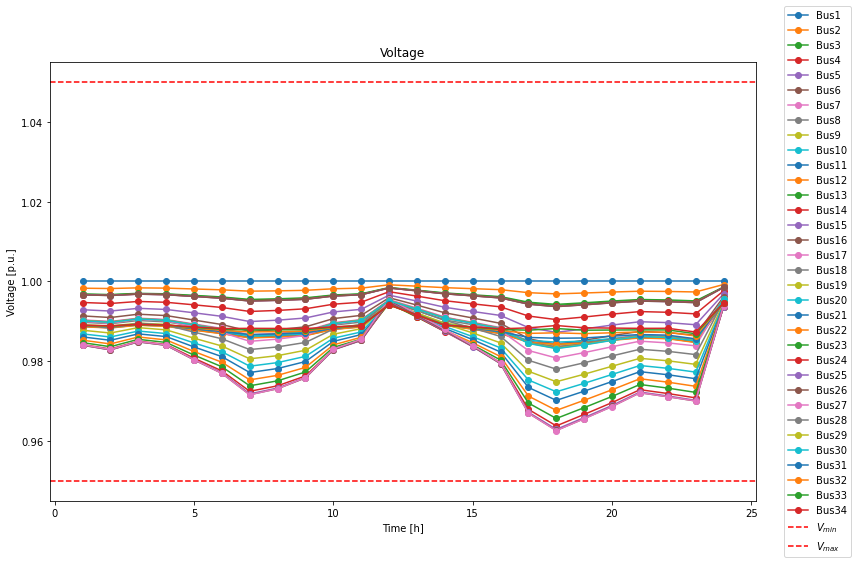

In [41]:
# Active and reactive power demand and supply (supply only from from slack bus)
fig_pow, ax_pow = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_pow[0,0].plot(active_d.index, active_d, marker='o');ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Demand');
ax_pow[0,1].plot(reactive_d.index, reactive_d, marker='o');ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Demand');
ax_pow[1,0].plot(active_s.index, active_s, marker='o');ax_pow[1,0].set_xlabel('Time [h]');ax_pow[1,0].set_ylabel('Active Power [kW]');ax_pow[1,0].set_title('Active Power Supply');
ax_pow[1,1].plot(reactive_s.index, reactive_s, marker='o');ax_pow[1,1].set_xlabel('Time [h]');ax_pow[1,1].set_ylabel('Reactive Power [kVar]');ax_pow[1,1].set_title('Reactive Power Supply');
fig_pow.legend(['Bus'+str(i) for i in active_d.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pow.tight_layout()
fig_pow.show;
plt.savefig('power.png', bbox_inches='tight')

# PV active power generation
fig_pv, ax_pv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_pv[0,0].plot(active_pv.index, active_pv, marker='o');ax_pv[0,0].set_xlabel('Time [h]');ax_pv[0,0].set_ylabel('Active Power [kW]');ax_pv[0,0].set_title('PV Active Power Supply');
fig_pv.legend(['Bus'+str(i) for i in active_pv.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pv.tight_layout()
fig_pv.show;
plt.savefig('pv.png', bbox_inches='tight')

# Wind active and reactive power supply
fig_wt, ax_wt = plt.subplots(nrows=2, ncols=1, squeeze=False, figsize=(12,8))
ax_wt[0,0].plot(active_wt.index, active_wt, marker='o');ax_wt[0,0].set_xlabel('Time [h]');ax_wt[0,0].set_ylabel('Active Power [kW]');ax_wt[0,0].set_title('Wind Active Power Supply');
ax_wt[1,0].plot(reactive_wt.index, reactive_wt, marker='o');ax_wt[1,0].set_xlabel('Time [h]');ax_wt[1,0].set_ylabel('Active Power [kW]');ax_wt[1,0].set_title('Wind Reactive Power Supply');
fig_wt.legend(['Bus'+str(i) for i in active_wt.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_wt.tight_layout()
fig_wt.show;
plt.savefig('wt.png', bbox_inches='tight')

# Distributed generation supply
fig_dg, ax_dg = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_dg[0,0].plot(active_dg.index, active_dg, marker='o');ax_dg[0,0].set_xlabel('Time [h]');ax_dg[0,0].set_ylabel('Active Power [kW]');ax_dg[0,0].set_title('DG Active Power Supply');
ax_dg[0,1].plot(active_dg.index, reactive_dg, marker='o');ax_dg[0,1].set_xlabel('Time [h]');ax_dg[0,1].set_ylabel('Reactive Power [kVar]');ax_dg[0,1].set_title('DG Reactive Power Supply');
ax_dg[1,0].plot(active_dg.index, u_dg, marker='o');ax_dg[1,0].set_xlabel('Time [h]');ax_dg[1,0].set_ylabel('State');ax_dg[1,0].set_title('DG working state');
ax_dg[1,1].plot(active_dg.index, fuel_dg, marker='o');ax_dg[1,1].set_xlabel('Time [h]');ax_dg[1,1].set_ylabel('Fuel [m$^3$]');ax_dg[1,1].set_title('DG fuel');
fig_dg.legend(['Bus'+str(i) for i in active_dg.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_dg.tight_layout()
fig_dg.show;
plt.savefig('dg.png', bboch_inches='tight')

# Voltage profile
b=['Bus'+str(i) for i in active_d.columns]
b.extend({'$V_{min}$','$V_{max}$'})
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_v[0,0].plot(voltage.index, voltage, marker='o');ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--')
ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--')
ax_v[0,0].legend(b, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig_v.tight_layout()
fig_v.show;
plt.savefig('voltage.png', bbox_inches='tight')

# Current profile
fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_i[0,0].plot(loading.index, loading, marker='o');ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [p.u.]');ax_i[0,0].set_title('Current');
fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_i.tight_layout()
fig_i.show;
plt.savefig('current.png', bbox_inches='tight')

# SOC and charging state of storage systems
fig_ees, ax_ees = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_ees[0,0].plot(SoC.index, SoC, marker='o');ax_ees[0,0].set_xlabel('Time [h]');ax_ees[0,0].set_ylabel('SoC [%]');ax_ees[0,0].set_title('State of Charge');
ax_ees[0,1].plot(active_ch.index, active_ch, marker='o');ax_ees[0,1].set_xlabel('Time [h]');ax_ees[0,1].set_ylabel('Active Power [kW]');ax_ees[0,1].set_title('Charging Active Power');
ax_ees[1,0].plot(u_ess.index, u_ess, marker='o');ax_ees[1,0].set_xlabel('Time [h]');ax_ees[1,0].set_ylabel('State');ax_ees[1,0].set_title('Charging State');
ax_ees[1,1].plot(active_dis.index, active_dis, marker='o');ax_ees[1,1].set_xlabel('Time [h]');ax_ees[1,1].set_ylabel('Active Power [kW]');ax_ees[1,1].set_title('Discharging Active Power');
fig_ees.legend(['Bus' + str(s) for s in SoC.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_ees.tight_layout()
fig_ees.show;
plt.savefig('ees.png', bbox_inches='tight')

In [42]:
for k in model.NODES:
    for t in model.TIME:
        m = model.Ps[k,t].value**2 + model.Qs[k,t].value**2 <= model.Ss_max[k].value**2
        if not m:
            print('Substation limit reached')